### Hypothesis test
- T test to compare the means of each batch to verify improvement for $i \in epochs$ 
- Bootsrapping
- Permutation test 

In [74]:
from bayesian_optimization import BayesianOptimization
import pandas as pd 
import numpy as np
from botorch.test_functions import Ackley
from botorch.test_functions import Levy 
from botorch.test_functions import Beale
from botorch.test_functions import DixonPrice
from botorch.test_functions import DropWave
from botorch.test_functions import Hartmann
from botorch.test_functions import Michalewicz
# Variables that determine the size of the dataset
N_INITIAL = 50
EPOCHS = 10
BATCH_SIZE = 10
DIM = 2
LOWER = 0
UPPER = np.pi

optimizer = BayesianOptimization(fun=Michalewicz(dim=DIM,negate=True), 
                                 batch_size=BATCH_SIZE, 
                                 dim=DIM, 
                                 epochs=EPOCHS, 
                                 n_init=N_INITIAL, 
                                 lower_bound=LOWER,
                                 upper_bound=UPPER,
                                 seed=5,
                                 acqf_type='qUCB')

x_max, y_max = optimizer.run()
data = optimizer.get_data()
full = optimizer.format(data, dim=DIM, n_init=N_INITIAL, batch_size=BATCH_SIZE, epochs=EPOCHS)
display(full)

,Batch,x1,x2,y
0,0.0,1.508877,0.368380,2.680798e-04
1,0.0,2.983848,2.334267,1.065940e-10
2,0.0,2.011948,1.028061,4.032438e-01
3,0.0,0.517131,2.993761,8.124531e-07
4,0.0,0.119094,1.225528,1.651159e-02
...,...,...,...,...
145,10.0,2.783679,0.703290,2.891963e-05
146,10.0,1.564806,0.276240,8.658574e-04
147,10.0,2.429334,1.072306,2.498878e-01
148,10.0,2.203018,1.570491,1.801299e+00


### Permutation test

In [75]:
import numpy as np
import pandas as pd


def permutation_test_max(id2, id1, n_permutations=100000, df=full):
    X = df[df['Batch'] == id2][['y']].to_numpy()
    Y = df[df['Batch'] == id1][['y']].to_numpy()

    np.random.seed(0)
    combined = np.concatenate([X, Y])
    n = len(X)
    obs_diff = np.max(X) - np.max(Y)
    
    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        X_permuted = combined[:n]
        Y_permuted = combined[n:]
        max_diff = np.max(X_permuted) - np.max(Y_permuted)
        perm_diffs.append(max_diff)
        
    p_value = np.mean(perm_diffs > obs_diff)
    return np.array(perm_diffs), obs_diff, p_value

In [61]:
perm_diffs, obs_diff_perm, p_value = permutation_test_max(id2=1, id1=0, n_permutations=10000,df=full)

print(f"Permutation Observed difference of maxima (normalized): {obs_diff_perm}")
print(f"Permutation p-value: {p_value}")

Permutation Observed difference of maxima (normalized): 0.3643506566669673
Permutation p-value: 0.0272


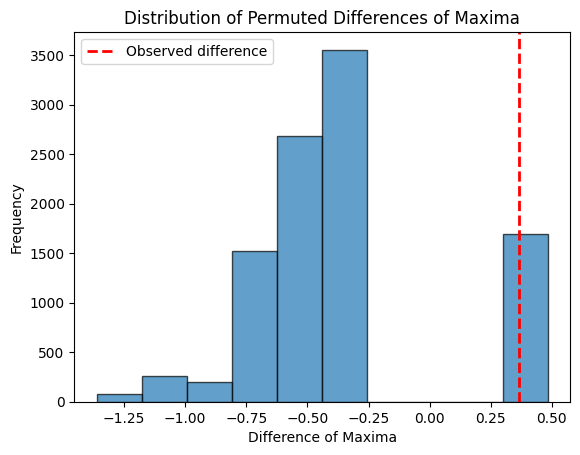

In [76]:
import matplotlib.pyplot as plt

plt.hist(perm_diffs, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(obs_diff_perm, color='r', linestyle='--', linewidth=2, label='Observed difference')
plt.title('Distribution of Permuted Differences of Maxima')
plt.xlabel('Difference of Maxima')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### T-test

In [77]:
import pandas as pd
from scipy.stats import ttest_ind

batches = full['Batch'].unique()
ttest_results = []
batch_0 = full[full['Batch'] == 0]['y']

for t in batches:
    if t != 0:
        batch_t = full[full['Batch'] == t]['y']
        t_stat, p_value = ttest_ind(batch_t, batch_0, alternative='greater')
        ttest_results.append({
            'Batch': f'Batch {t} vs Batch 0',
            't-statistic': round(t_stat, 2),
            'p-value': round(p_value, 4)
        })

# Create a DataFrame
results_df = pd.DataFrame(ttest_results)

print(results_df)

                   Batch  t-statistic  p-value
0   Batch 1.0 vs Batch 0         1.46   0.0745
1   Batch 2.0 vs Batch 0         1.04   0.1515
2   Batch 3.0 vs Batch 0         0.73   0.2330
3   Batch 4.0 vs Batch 0        -0.07   0.5290
4   Batch 5.0 vs Batch 0        -0.14   0.5537
5   Batch 6.0 vs Batch 0        -0.03   0.5103
6   Batch 7.0 vs Batch 0         2.02   0.0239
7   Batch 8.0 vs Batch 0         1.99   0.0258
8   Batch 9.0 vs Batch 0         0.49   0.3142
9  Batch 10.0 vs Batch 0         0.72   0.2359


### Bootstrapping

In [72]:
import numpy as np
import pandas as pd



def get_batches(id1,id2,data):
    cols = ['Batch','y']
    df = data[cols]
    y_0 = df[df['Batch'] == id1][['y']].to_numpy()
    y_1 = df[df['Batch'] == id2][['y']].to_numpy()
    return y_0, y_1


def bootstrap_diff_max(X, Y, n_bootstrap=1000):
    np.random.seed(0)
    max_diffs = []

    X = X.squeeze()
    Y = Y.squeeze()
    
    for _ in range(n_bootstrap):
        X_resample = np.random.choice(X, size=len(X), replace=True)
        Y_resample = np.random.choice(Y, size=len(Y), replace=True)
        max_diff = np.max(X_resample) - np.max(Y_resample)
        max_diffs.append(max_diff)
        
    # Calculating the confience intervals    
    max_diffs_bootstrap = np.array(max_diffs)
    obs_diff = np.max(X) - np.max(Y)
    lower_bound_bootstrap = np.percentile(max_diffs_bootstrap, 5)
    upper_bound_bootstrap = np.percentile(max_diffs_bootstrap, 97.5)
    print(f"Bootstrap Observed difference of maxima: {obs_diff}")
    # print(f"Bootstrap Observed difference of maxima: {max_diffs_bootstrap}")
    print(f"Bootstrap 95% Confidence interval: [{lower_bound_bootstrap}, {upper_bound_bootstrap}]")

In [78]:
y1, y2 = get_batches(1,0,full)
print(y1,y2)

bootstrap_diff_max(y1, y2)

[[9.95408561e-01]
 [7.76001846e-16]
 [1.61763343e-18]
 [1.27892784e-06]
 [1.15414843e-04]
 [9.04647319e-03]
 [3.28301741e-01]
 [1.32035622e+00]
 [1.10130351e+00]
 [4.73552393e-08]] [[2.68079818e-04]
 [1.06593958e-10]
 [4.03243806e-01]
 [8.12453146e-07]
 [1.65115898e-02]
 [1.07697953e-03]
 [3.32683504e-02]
 [2.47670762e-01]
 [7.37395309e-06]
 [2.32999223e-01]
 [8.52106509e-02]
 [5.89223805e-06]
 [5.93997234e-13]
 [8.58931176e-01]
 [9.89984836e-01]
 [3.94393803e-01]
 [2.59716082e-01]
 [2.33286755e-02]
 [6.51084993e-01]
 [5.24321060e-04]
 [1.26014316e-36]
 [1.03563001e-01]
 [1.63625023e-01]
 [3.29183622e-01]
 [1.25324034e-09]
 [9.96835295e-01]
 [1.70617591e-01]
 [3.66000285e-03]
 [2.17102628e-03]
 [7.16423141e-01]
 [1.04887326e-26]
 [4.19781611e-05]
 [1.21580405e-04]
 [1.85064423e-07]
 [5.71991875e-01]
 [1.14851735e-17]
 [6.43743971e-17]
 [5.82114503e-01]
 [2.20123832e-02]
 [3.75720095e-06]
 [8.65503681e-14]
 [7.32897993e-02]
 [2.19832624e-01]
 [1.66212044e-02]
 [7.89200489e-01]
 [8.77779